# Algorithmic Trading Strategy Challenge

Name: Justin Chen

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio. <br>
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file. <br>
You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk. <br>
Your solution can be based on machine learning, technical analysis, or any other approach you find suitable. <br>
Be creative and demonstrate your coding ability in this challenge. <br>
In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time. <br>
Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


## Strategy Implementation

### Description of Strategy Implementation
Last semester, I created an algorithmic trading strategy by combining the first/second derivatives of the ONV + 1st/second derivates of the 30 day moving average (to determine buy/sell), and Bollinger Band values to determine quantity to buy/sell (measure of risk), to perform trade on a specific stock. <br />
<br />
So this year, we're going to see if we can have a multi-linear regression model do the job for us instead of trying to code a strategy using technical analysis. <br />
<br />
We're also only going to be buying/selling because the SSMIF overlords will hunt me down if I mention the word shorting within 500 miles of Stevens

### Strategy Steps:
1. Gather all available stocks we have in dummy_data portfolio
2. Gather the timeframe of stocks we have in dummy_data portfolio, and fetch data of stocks 5 years before that date
3. Create a class object to hold all technical indicators we're going to put into the multi-linear regression model
4. Calculate technical indicators (1st d/dx of OBV, 2nd d/dx of OBV, MACD, EMAs, 30 day moving average, d/dx of that, moving average of past week, d/dx of moving average of past week, Bollinger Bands, RSI)
5. Calculate rate of change of a stock (what we're trying to eventually predict)
6. Plug into multilinear regression (very risky move here because I can't find any literature that does it on technical indicators and 1st rate of change but fortune favors the bold XD)
7. Use multilinear regression on a given stock in dummy_data
8. Get the rate of change of stock for every stock we have in the portfolio. `Find the absolute value of them, sum it, divide each number by the sum` to determine their relative proportions. Then, divide it up by total asset price.
9. If rate of change is positive, rellocate portfolio such that each stock matches that relative proportion. If it's negative, we sell it all. We can always just buy more on the next trading day.

### Library Imports

In [65]:
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Got basic template for training/testing the ML code from CS club ML presentation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

### Portfolio Data
We're just going to list the stocks available for us to use and initial capital.

In [66]:
BUYING_POWER = 200000
STOCKS_AVAILABLE = [
    "AAPL",
    "META",
    "MSFT",
    "NVDA",
    "TSLA",
    "XOM",
    "JPM",
    "JNJ",
    "SPY",
    "AMZN",
    "GOOG"
]

### Creating Class

Create a class to hold all important technical indicators on a Stock.
We also download data 30 trading days before the official start date because we'll need that for the moving average

In [67]:
class StockData:    # The class is more of a dictionary type object so we can store things. Calculations will be done outside of class
    def __init__(self, ticker:str, start_date:datetime, end_date:datetime):
        # Init variables
        self.df = pd.DataFrame()

        self.ticker = ticker
        self.start_date = start_date
        self.thirty_b4_start_date = start_date - timedelta(days=50)     # Realistically, we're only going to get 30 trading days
        self.end_date = end_date

        self.fetch_stocks()
        self.calculate_diff()

        self.macd = None
        self.thirty_day_ma = None
        self.f_div_thirty_dat_ma = None
        self.seven_day_ma = None
        self.f_div_seven_day_ma = None

    def fetch_stocks(self):
        '''
        Downloads stocks from 30 trading days before start data and end date
        Then, it adjusts the adj_closes and volumes
        '''
        stock_df = yf.download(self.ticker, self.thirty_b4_start_date, self.end_date)
        self.df["Adj Close"] = stock_df["Adj Close"]
        self.df["Volume"] = stock_df["Volume"]
        self.df["High"] = stock_df["High"]
        self.df["Low"] = stock_df["Low"]

    def calculate_diff(self):
        '''
        Calculate the daily difference between adj close
        '''
        self.df["Delta Close"] = self.df["Adj Close"].diff()
        self.df["% Change"] = self.df["Adj Close"].pct_change()


For testing purposes (to see if things work), we will set AAPL from 2020 - 2022 as dummy data

In [68]:
# Dummy class example
DUMMY_STOCK = StockData("AAPL", datetime(2020, 1, 1), datetime(2022, 1, 1))

# To display all rows
pd.set_option('display.max_rows', None)

# To display all columns
pd.set_option('display.max_columns', None)

[*********************100%***********************]  1 of 1 completed


### Calculating Technical Indicators

First, we calculate `O`n `B`alance `V`olume. 
* If current closing price is higher than previous closing price, add volume
* If current closing price is lower, subtract volume
* Else, do nothing

Then, find the derivatives of the thing, so OBV by itself is an arbritrary number and is kind of useless

In [69]:
def find_obv(stock:StockData):
    for date, volume in stock.df["Volume"].items():

        # If delta close is undefined, set OBV to 0 as it's the first item in the stockdata
        if pd.isna(stock.df.loc[date, "Delta Close"]):
            stock.df.loc[date, "OBV"] = 0
        elif stock.df.loc[date, "Delta Close"] < 0: # If change between today and yesterday's close is negative, today close < yesterday close
            stock.df.loc[date, "OBV"] = stock.df.shift().loc[date, "OBV"] - volume 
        elif stock.df.loc[date, "Delta Close"] > 0: # If positive, today close > yesterday close
            stock.df.loc[date, "OBV"] = stock.df.shift().loc[date, "OBV"] + volume
        else:
            # Rate of change is 0
            stock.df.loc[date, "OBV"] = stock.df.shift().loc[date, "OBV"]

def find_derivatives_obv(stock:StockData):
    stock.df["OBV'"] = stock.df["OBV"].diff() / stock.df.index.to_series().diff().dt.days
    stock.df["OBV''"] = stock.df["OBV'"].diff() / stock.df.index.to_series().diff().dt.days

# Testing
find_obv(DUMMY_STOCK)
find_derivatives_obv(DUMMY_STOCK)
print(DUMMY_STOCK.df[["Adj Close", "Delta Close", "OBV", "OBV'", "OBV''"]])

             Adj Close  Delta Close           OBV          OBV'         OBV''
Date                                                                         
2019-11-12   63.886509          NaN  0.000000e+00           NaN           NaN
2019-11-13   64.498650     0.612141  1.027344e+08  1.027344e+08           NaN
2019-11-14   64.052353    -0.446297  1.355160e+07 -8.918280e+07 -1.919172e+08
2019-11-15   64.813255     0.760902  1.137580e+08  1.002064e+08  1.893892e+08
2019-11-18   65.140053     0.326797  2.004612e+08  2.890107e+07 -2.376844e+07
2019-11-19   64.942520    -0.197533  1.242940e+08 -7.616720e+07 -1.050683e+08
2019-11-20   64.186485    -0.756035  1.805960e+07 -1.062344e+08 -3.006720e+07
2019-11-21   63.898720    -0.287766 -1.033356e+08 -1.213952e+08 -1.516080e+07
2019-11-22   63.842606    -0.056114 -1.686608e+08 -6.532520e+07  5.607000e+07
2019-11-25   64.962006     1.119400 -8.464040e+07  2.800680e+07  3.111067e+07
2019-11-26   64.454758    -0.507248 -1.898480e+08 -1.052076e+08 

Now, let's find the 7 day moving average of each stock, its derivative, and its second derivative.
According to investopedia, moving average uses trading days (which yfinance indexes on), so we can just find the mean of the rolling sum of the last 7 entries.


In [70]:
def find_7_day_MA(stock:StockData):
    stock.df["7dma"] = stock.df["Adj Close"].rolling(window=7).mean()

def find_derivatives_7dma(stock:StockData):
    stock.df["7dma'"] = stock.df["7dma"].diff() / stock.df.index.to_series().diff().dt.days
    stock.df["7dma''"] = stock.df["7dma'"].diff() / stock.df.index.to_series().diff().dt.days

find_7_day_MA(DUMMY_STOCK)
find_derivatives_7dma(DUMMY_STOCK)
print(DUMMY_STOCK.df[["Adj Close", "7dma", "7dma'", "7dma''"]])

             Adj Close        7dma     7dma'    7dma''
Date                                                  
2019-11-12   63.886509         NaN       NaN       NaN
2019-11-13   64.498650         NaN       NaN       NaN
2019-11-14   64.052353         NaN       NaN       NaN
2019-11-15   64.813255         NaN       NaN       NaN
2019-11-18   65.140053         NaN       NaN       NaN
2019-11-19   64.942520         NaN       NaN       NaN
2019-11-20   64.186485   64.502832       NaN       NaN
2019-11-21   63.898720   64.504577  0.001744       NaN
2019-11-22   63.842606   64.410856 -0.093721 -0.095465
2019-11-25   64.962006   64.540806  0.043317  0.045679
2019-11-26   64.454758   64.489592 -0.051214 -0.094531
2019-11-27   65.320526   64.515374  0.025782  0.076996
2019-11-29   65.176636   64.548819  0.016723 -0.004530
2019-12-02   64.423050   64.582614  0.011265 -0.001819
2019-12-03   63.274376   64.493422 -0.089192 -0.100457
2019-12-04   63.832855   64.492029 -0.001393  0.087799
2019-12-05

Now, we calculate the 30 day moving average. This uses the same equation as the 7 day moving average.<br>
We do get a lot of NAN values (since those don't have 30 days of adj close data), but that is why we fetched data up to 50 IRL days before the start_date

In [71]:
def find_30_day_MA(stock:StockData):
    stock.df["30dma"] = stock.df["Adj Close"].rolling(window=30).mean()

def find_derivatives_30dma(stock:StockData):
    stock.df["30dma'"] = stock.df["30dma"].diff() / stock.df.index.to_series().diff().dt.days
    stock.df["30dma''"] = stock.df["30dma'"].diff() / stock.df.index.to_series().diff().dt.days

find_30_day_MA(DUMMY_STOCK)
find_derivatives_30dma(DUMMY_STOCK)
print(DUMMY_STOCK.df[["Adj Close", "30dma", "30dma'", "30dma''"]])

             Adj Close       30dma    30dma'   30dma''
Date                                                  
2019-11-12   63.886509         NaN       NaN       NaN
2019-11-13   64.498650         NaN       NaN       NaN
2019-11-14   64.052353         NaN       NaN       NaN
2019-11-15   64.813255         NaN       NaN       NaN
2019-11-18   65.140053         NaN       NaN       NaN
2019-11-19   64.942520         NaN       NaN       NaN
2019-11-20   64.186485         NaN       NaN       NaN
2019-11-21   63.898720         NaN       NaN       NaN
2019-11-22   63.842606         NaN       NaN       NaN
2019-11-25   64.962006         NaN       NaN       NaN
2019-11-26   64.454758         NaN       NaN       NaN
2019-11-27   65.320526         NaN       NaN       NaN
2019-11-29   65.176636         NaN       NaN       NaN
2019-12-02   64.423050         NaN       NaN       NaN
2019-12-03   63.274376         NaN       NaN       NaN
2019-12-04   63.832855         NaN       NaN       NaN
2019-12-05

Now, let's calculate the MACD. <br>
But before that, we'll need to find the 26 day and 12 day exponential moving average.

First, let `alpha = (smoothing) / (1 + number days)` <br>
I set smoothing number to be 3 (as opposed to 2) since I want the more recent data to weigh more (since we already have 7 and 30 day MAs)

The exponential moving average formula (https://www.investopedia.com/terms/e/ema.asp) is hence: <br>
`EMA = (alpha * Adj Close) + EMA_yesterday * (1 - alpha)` 

Funny story: I was fuming when I did all this by hand for last semester's SSMIF application and found out 2 weeks later that pandas literally has a function that does that for you :(

In [72]:
def find_MACD(stock:StockData):
    '''
    Calculates the MACD of a stock
    In the mean time, we can add the 12 and 26 day EMA into the dataframe because more data == better for regression models
    '''
    twelve_alpha = 3 / 13
    twenty_six_alpha = 3 / 27

    stock.df["12 Day EMA"] = stock.df["Adj Close"].ewm(alpha=twelve_alpha, adjust=False, min_periods=12).mean()
    stock.df["26 Day EMA"] = stock.df["Adj Close"].ewm(alpha=twenty_six_alpha, adjust=False, min_periods=26).mean()
    stock.df["MACD"] = stock.df["12 Day EMA"] - stock.df["26 Day EMA"]

def find_derivatives_MACD(stock:StockData):
    stock.df["MACD'"] = stock.df["MACD"] = stock.df["MACD"].diff() / stock.df.index.to_series().diff().dt.days
    
find_MACD(DUMMY_STOCK)
find_derivatives_MACD(DUMMY_STOCK)
print(DUMMY_STOCK.df[['Adj Close', "12 Day EMA", "26 Day EMA", "MACD", "MACD'"]])

             Adj Close  12 Day EMA  26 Day EMA      MACD     MACD'
Date                                                              
2019-11-12   63.886509         NaN         NaN       NaN       NaN
2019-11-13   64.498650         NaN         NaN       NaN       NaN
2019-11-14   64.052353         NaN         NaN       NaN       NaN
2019-11-15   64.813255         NaN         NaN       NaN       NaN
2019-11-18   65.140053         NaN         NaN       NaN       NaN
2019-11-19   64.942520         NaN         NaN       NaN       NaN
2019-11-20   64.186485         NaN         NaN       NaN       NaN
2019-11-21   63.898720         NaN         NaN       NaN       NaN
2019-11-22   63.842606         NaN         NaN       NaN       NaN
2019-11-25   64.962006         NaN         NaN       NaN       NaN
2019-11-26   64.454758         NaN         NaN       NaN       NaN
2019-11-27   65.320526   64.616850         NaN       NaN       NaN
2019-11-29   65.176636   64.746031         NaN       NaN      

Now, let's calculate RSI.<br>
Since we are trying to algo trade based on the rate of change (trend following) on, it's helpful to add a momentum indicator to see if a stock is overbought/oversold, and whether that's primed for a change in d/dx(stock price) or d2y/dx2(stock price)

The formula for RSI is: 
* For the first day, take the `100 - 100 / [1 + (14 day average % gain / 14 day average % loss)]`
* For subsequent days, take `100 - [100/ {(Previous average % gain * 13) + current % Gain} / {(Previous average % loss * 13) + current % loss}]`

In [73]:
# Source: Rewrote function from Algo Trading challenge last semester
# Again, RSI calculations may differ a bit from other sources online because this is a recursive formula, and our time window won't 100% match 
def calculate_rsi(stock:StockData, window:int=14):
        # The first element in RSI = 100 - (100 / 1 + RS ), where RS = (average % gain over 14 days / average % loss over 14 days)
        gain = 0
        loss = 0
        
        # Not using first day data because there is no percent change
        # Also, it was a good thing that we calculated delta close earlier
        for i in range(1, window + 1):
            price_diff = stock.df.loc[stock.df.index[i], "% Change"]
            #print(price_diff)

            if (price_diff < 0):
                loss += abs(price_diff)
            else:
                gain += abs(price_diff)

        avg_gain = gain / window
        avg_loss = loss / window
        
        if (avg_loss == 0):
            stock.df.loc[stock.df.index[window], "RSI"] = 100 # Edge case that uses infinity - if average loss (and hence loss because math) is 0, RSI == 100
        else:
            stock.df.loc[stock.df.index[window], "RSI"] = (100 - (100 / (1 + (avg_gain / avg_loss))))

        # Reset vars to use later
        loss = 0
        gain = 0

        # Now, let's do the second equation. Loop through the entire df
        for i in range(window + 1, len(stock.df.index)):
            price_diff = stock.df.loc[stock.df.index[i], "% Change"]

            if (price_diff < 0):
                loss = abs(price_diff)
                gain = 0
            elif (price_diff > 0):
                loss = 0
                gain = price_diff

            avg_gain = (avg_gain * (window - 1) + gain) / window
            avg_loss = (avg_loss * (window - 1) + loss) / window

            if (avg_loss == 0):
                stock.df.loc[stock.df.index[i], "RSI"] = 100 # Edge case that uses infinity - if average loss (and hence loss because math) is 0, RSI == 100
            else:
                rs = avg_gain / avg_loss
                rsi = 100 - (100 / (1 + (rs)))
                stock.df.loc[stock.df.index[i], "RSI"] = rsi

calculate_rsi(DUMMY_STOCK)
print(DUMMY_STOCK.df[["% Change", "RSI"]])

            % Change        RSI
Date                           
2019-11-12       NaN        NaN
2019-11-13  0.009582        NaN
2019-11-14 -0.006919        NaN
2019-11-15  0.011879        NaN
2019-11-18  0.005042        NaN
2019-11-19 -0.003032        NaN
2019-11-20 -0.011642        NaN
2019-11-21 -0.004483        NaN
2019-11-22 -0.000878        NaN
2019-11-25  0.017534        NaN
2019-11-26 -0.007808        NaN
2019-11-27  0.013432        NaN
2019-11-29 -0.002203        NaN
2019-12-02 -0.011562        NaN
2019-12-03 -0.017830  46.410577
2019-12-04  0.008826  50.230948
2019-12-05  0.014671  55.863366
2019-12-06  0.019316  61.966368
2019-12-09 -0.014000  55.929917
2019-12-10  0.005844  57.778903
2019-12-11  0.008530  60.390946
2019-12-12  0.002548  61.163877
2019-12-13  0.013593  65.078970
2019-12-16  0.017118  69.278979
2019-12-17  0.001965  69.729113
2019-12-18 -0.002389  68.416628
2019-12-19  0.001001  68.682592
2019-12-20 -0.002071  67.417424
2019-12-23  0.016318  71.821184
2019-12-

Now, we find ADX (https://therobusttrader.com/adx/)
This is a pretty good indicator for our multilinear regression model because it tells you both the direction and strength of the trend

To calculate the ADX:
* Create a positive directional movement indicator `current high - previous high if > 0 and > -DM. Otherwise, 0`
* Crete a negative directional movement indicator `current low - previous low if > 0 and > +DM. Otherwise, 0`
* Find positive directional indicator, which is EMA(+DM) * 100/ period (14)
* Find negative directional indicator, which is EMA(-DM) * 100/ period (14)
* Now to find ADX, find (+DI - -DI) / (+DI + -DI)
* Now, just find EMA of that

In [74]:
def find_adx(stock:StockData, period:int=14):
    # Calculate the directional movement indicator
    positive_dm = pd.Series(dtype=float)
    negative_dm = pd.Series(dtype=float)

    for i in range(1, len(stock.df.index)):
        prev_row_name = stock.df.index[i - 1]       # The loop starts at 1 to make sure this isn't out of bounds
        row_name = stock.df.index[i]

        diff_high = stock.df.loc[row_name, "High"] - stock.df.loc[prev_row_name, "High"]
        diff_low = stock.df.loc[row_name, "Low"] - stock.df.loc[prev_row_name, "Low"]

        # Create positive movement indicator value if > 0 and > -DM. Otherwise 0
        if diff_high > 0 and diff_high > diff_low:
            positive_dm[row_name] = diff_high
        else:
            positive_dm[row_name] = 0
        
        # Create negative movement indicator value if > 0 and > +DM. Otherwise 0
        if diff_low > 0 and diff_low > diff_high:
            negative_dm[row_name] = diff_low
        else:
            negative_dm[row_name] = 0
        
    # Find positive directional indicator and negative directional indicator
    positive_dir_indicator = (positive_dm.ewm(span=2, adjust=False, min_periods=period).mean() * 100) / period
    negative_dir_indicator = (negative_dm.ewm(span=2, adjust=False, min_periods=period).mean() * 100) / period
    
    # print(positive_dir_indicator, negative_dir_indicator)
    
    # Find ADX
    di_diff = (positive_dir_indicator - negative_dir_indicator) / (positive_dir_indicator + negative_dir_indicator)
    #print(di_diff)
    stock.df["ADX"] = (di_diff.ewm(span=2, adjust=False).mean() * 100)

find_adx(DUMMY_STOCK)
print(DUMMY_STOCK.df[["High", "Low", "ADX"]])

                  High         Low        ADX
Date                                         
2019-11-12   65.697502   65.230003        NaN
2019-11-13   66.195000   65.267502        NaN
2019-11-14   66.220001   65.525002        NaN
2019-11-15   66.445000   65.752502        NaN
2019-11-18   66.857498   66.057503        NaN
2019-11-19   67.000000   66.347504        NaN
2019-11-20   66.519997   65.099998        NaN
2019-11-21   66.002502   65.294998        NaN
2019-11-22   65.794998   65.209999        NaN
2019-11-25   66.610001   65.629997        NaN
2019-11-26   66.790001   65.625000        NaN
2019-11-27   66.995003   66.327499        NaN
2019-11-29   67.000000   66.474998        NaN
2019-12-02   67.062500   65.862503        NaN
2019-12-03   64.882500   64.072502 -23.351289
2019-12-04   65.827499   65.169998 -73.402581
2019-12-05   66.472504   65.682503  -6.311079
2019-12-06   67.750000   66.824997  54.377943
2019-12-09   67.699997   66.227501  74.607617
2019-12-10   67.517502   66.464996

### Calculate stats for All Available Stocks

We'll store all the stockdata class objects inside a dictionary

In [75]:
stock_dict:StockData = dict()

Now, we iterate through the available stocks we have, create classes for them, calculate technical indicators for those stocks, and put the class object into stock_dict

In [76]:
for stock_ticker in STOCKS_AVAILABLE:
    stock = StockData(stock_ticker, datetime(2018, 1, 1), datetime(2023, 10, 15))
    find_obv(stock)
    find_derivatives_obv(stock)
    find_7_day_MA(stock)
    find_derivatives_7dma(stock)
    find_30_day_MA(stock)
    find_derivatives_30dma(stock)
    find_MACD(stock)
    find_derivatives_MACD(stock)
    calculate_rsi(stock)
    find_adx(stock)

    stock_dict[stock_ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Training Multilinear Regression

We want to train our multilinear regression on the % change of the stocks

First, let's create some scatter plots to see if there's some sort of correlation 

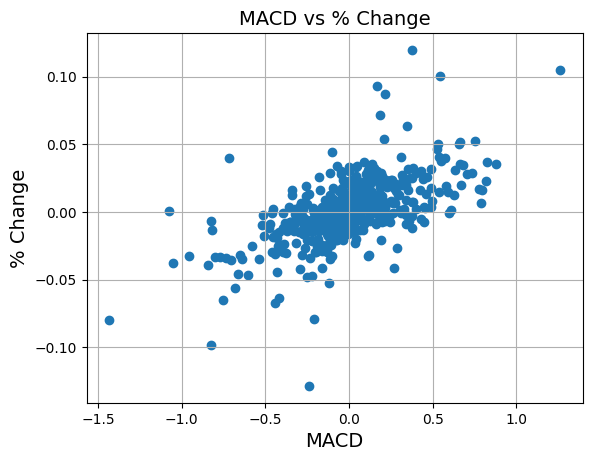

In [77]:
%matplotlib inline
plt.scatter(x=DUMMY_STOCK.df["MACD"], y=DUMMY_STOCK.df["% Change"])
plt.title('MACD vs % Change', fontsize=14)
plt.xlabel('MACD', fontsize=14)
plt.ylabel('% Change', fontsize=14)
plt.grid(True)

plt.show()

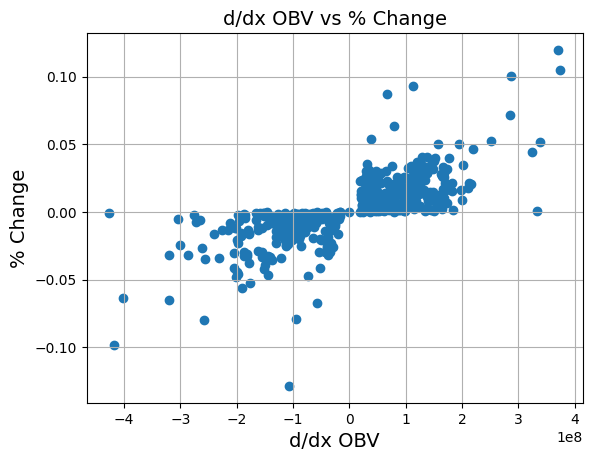

In [78]:
%matplotlib inline
plt.scatter(x=DUMMY_STOCK.df["OBV\'"], y=DUMMY_STOCK.df["% Change"])
plt.title('d/dx OBV vs % Change', fontsize=14)
plt.xlabel('d/dx OBV', fontsize=14)
plt.ylabel('% Change', fontsize=14)
plt.grid(True)

plt.show()

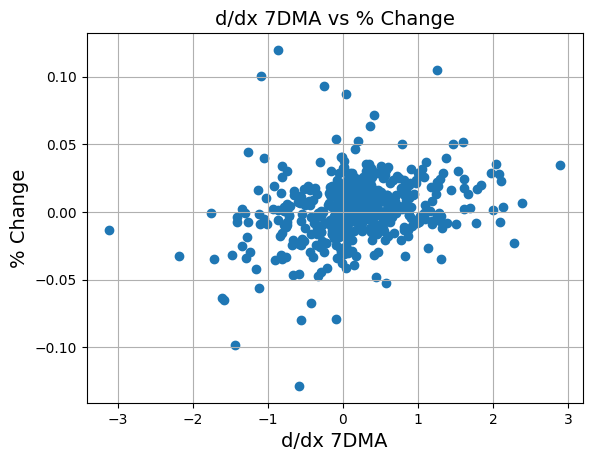

In [79]:
%matplotlib inline
plt.scatter(x=DUMMY_STOCK.df["7dma\'"], y=DUMMY_STOCK.df["% Change"])
plt.title('d/dx 7DMA vs % Change', fontsize=14)
plt.xlabel('d/dx 7DMA', fontsize=14)
plt.ylabel('% Change', fontsize=14)
plt.grid(True)

plt.show()

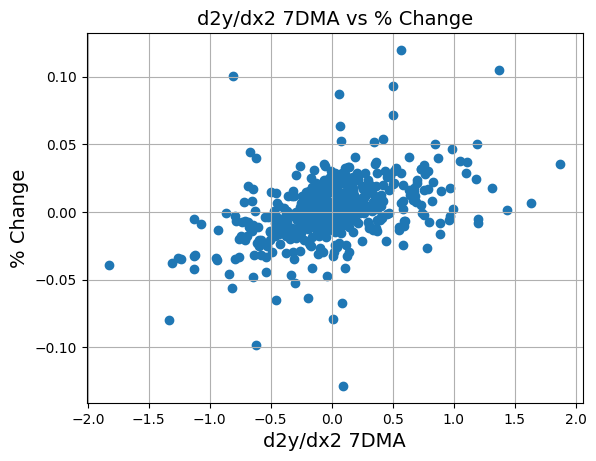

In [80]:
%matplotlib inline
plt.scatter(x=DUMMY_STOCK.df["7dma\'\'"], y=DUMMY_STOCK.df["% Change"])
plt.title('d2y/dx2 7DMA vs % Change', fontsize=14)
plt.xlabel('d2y/dx2 7DMA', fontsize=14)
plt.ylabel('% Change', fontsize=14)
plt.grid(True)

plt.show()

As we can see, there's some positive correlation between the technical indicators and percent change. <br>
That means we could move forward with multilinear regression.

The first thing we need to do is creating sets of data we can actually use for training the multilinear regression model.

In [81]:
TARGETED_CATEGORIES = ["12 Day EMA", "26 Day EMA", "30dma", "30dma\'", "30dma\'\'", "7dma", "7dma\'", "7dma\'\'", "ADX", "Adj Close", "MACD", "MACD\'", "OBV", "OBV\'", "OBV\'\'", "RSI"]

# Add all the data across all stocks into X and Y
x = pd.DataFrame(columns=TARGETED_CATEGORIES)
y = pd.DataFrame(columns=["% Change"])
counter = 0             # What we're indexing the pairs by (because dates won't work here)

for stock in stock_dict.values():
    # Increment counter while reindexing
    df_length = len(stock.df.index)
    df_rename_idx:dict = dict()

    for i in range(df_length):
        df_rename_idx[stock.df.index[i]] = counter
        counter += 1

    changed_df:pd.DataFrame = stock.df.iloc[31 : df_length - 1, :]     # stock.df will always have more than 31 values because we fetched 50 extra days'
    changed_df:pd.DataFrame = changed_df.rename(df_rename_idx)

    for idx, row in changed_df.iterrows():
        x.loc[idx] = row[TARGETED_CATEGORIES]
        y.loc[idx] = row["% Change"]

x_train, x_test, y_train, y_test = train_test_split( 
    x, y, test_size=0.25, random_state=50) 

### Determining Allocation + Trading

## Plot P/L

## Plot Liquidity